# Intersection with a crosswalk

**Load dependencies**

In [1]:
rng = MersenneTwister(1);

In [2]:
using POMDPs, POMDPToolbox, DiscreteValueIteration, MDPModelChecking
using AutomotiveDrivingModels, AutomotivePOMDPs
using Reel, AutoViz
using ProgressMeter
using JLD

In [3]:
include("masking.jl")
include("util.jl")
include("render_helpers.jl")

In [4]:
cam = FitToContentCamera(0.);

## Scenario

In [5]:
params = UrbanParams(nlanes_main=1,
                     crosswalk_pos =[VecSE2(6, 0., pi/2), VecSE2(-6, 0., pi/2), VecSE2(0., -5., 0.)],
                     crosswalk_length =  [14.0, 14., 14.0],
                     crosswalk_width = [4.0, 4.0, 3.1],
                     stop_line = 22.0)
env = UrbanEnv(params=params);

## Discrete MDP

In [6]:
mdp = PedCarMDP(env=env, pos_res=2.0, vel_res=2.);

In [7]:
@printf("spatial resolution %2.1f m \n", mdp.pos_res)
@printf("pedestrian velocity resolution %2.1f m/s \n", mdp.vel_ped_res)
@printf("car velocity resolution %2.1f m/s \n", mdp.vel_res)
@printf("number of states %d \n", n_states(mdp))
@printf("number of actions %d \n", n_actions(mdp))

spatial resolution 2.0 m 
pedestrian velocity resolution 1.0 m/s 
car velocity resolution 2.0 m/s 
number of states 23456940 
number of actions 4 


In [8]:
state_space = states(mdp);

In [9]:
# Load VI data for maksing
vi_data = JLD.load("pc_util_f.jld")
@showprogress for s in state_space
    if !s.crash && isterminal(mdp, s)
        si = state_index(mdp, s)
        vi_data["util"][si] = 1.0
        vi_data["qmat"][si, :] = ones(n_actions(mdp))
    end
end
policy = ValueIterationPolicy(mdp, vi_data["qmat"], vi_data["util"], vi_data["pol"]);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:1539m


In [18]:
# using NearestNeighbors, LocalApproximationValueIteration, LocalFunctionApproximation, StaticArrays
# data = JLD.load("pc_lavi_fine.jld")
# function convert_states(mdp::PedCarMDP, sampled_states::Vector{Int64})
#     n_routes = 4
#     n_features = 4
#     nd = n_features*3 + n_routes + 1
#     state_space = states(mdp)
#     points = Vector{SVector{nd, Float64}}(length(sampled_states))
#     for (i, si) in enumerate(sampled_states)
#         z = convert_s(Vector{Float64}, state_space[si], mdp)
#         points[i] = SVector{nd, Float64}(z...)
#     end
#     return points
# end
# sampled_states = data["sampled_states"]
# points = convert_states(mdp, sampled_states)
# nntree = KDTree(points)
# k = 6
# knnfa = LocalNNFunctionApproximator(nntree, points, k)
# set_all_interpolating_values(knnfa, data["values"])
# solver = LocalApproximationValueIterationSolver(knnfa)
# policy = LocalApproximationValueIterationPolicy(mdp, solver);

In [10]:
threshold = 0.9999
mask = SafetyMask(mdp, policy, threshold);

In [11]:
rand_pol = MaskedEpsGreedyPolicy(mdp, 1.0, mask, rng);
# rand_pol = solve(RandomSolver(), mdp);

In [12]:
hr = HistoryRecorder(rng=rng, max_steps=100)
s0 = initial_state(mdp, rng)
hist2 = simulate(hr, mdp, policy, s0);

In [13]:
h = hist2
state_hist = h.state_hist
action_hist = h.action_hist
push!(action_hist, UrbanAction(NaN))
duration, fps, render_hist = animate_states(mdp, state_hist, action_hist, mask)
film = roll(render_hist, fps = fps, duration = duration)

Reel.Frames{MIME{Symbol("image/png")}}("/tmp/tmp8b8yAQ", 0x0000000000000017, 2.0, nothing)

In [19]:
@time for ep=1:10000
    hr = HistoryRecorder(rng=rng, max_steps=100)
    s0 = initial_state(mdp, rng)
    hist2 = simulate(hr, mdp, rand_pol, s0)
    if sum(hist2.reward_hist .< 0.) != 0.
        println("Crash")
        break
    end
end

Crash
 18.557137 seconds (209.95 M allocations: 7.920 GiB, 35.60% gc time)


**Evaluation**

In [14]:
@time rewards_mask, steps_mask, violations_mask = evaluation_loop(mdp, policy, n_ep=10000, max_steps=100, rng=rng);
print_summary(rewards_mask, steps_mask, violations_mask)

111.127639 seconds (2.21 G allocations: 88.729 GiB, 13.81% gc time)
Summary for 10000 episodes: 
Average reward: 0.271 
Average # of steps: 28.801 
Average # of violations: 0.260 


## Continuous state MDP

In [15]:
params = UrbanParams(nlanes_main=1,
                     crosswalk_pos =[VecSE2(6, 0., pi/2), VecSE2(-6, 0., pi/2), VecSE2(0., -5., 0.)],
                     crosswalk_length =  [14.0, 14., 14.0],
                     crosswalk_width = [4.0, 4.0, 3.1],
                     stop_line = 22.0)
env = UrbanEnv(params=params);

In [16]:
pomdp = UrbanPOMDP(env=env,
                   ego_goal = LaneTag(2, 1),
                   max_cars=1, 
                   max_peds=1, 
                   car_birth=0.3, 
                   ped_birth=0.3, 
                   obstacles=false, # no fixed obstacles
                   lidar=false,
                   pos_obs_noise = 0., # fully observable
                   vel_obs_noise = 0.,
                   ego_start=20);

In [17]:
rand_pol = RandomMaskedPOMDPPolicy(mask, pomdp, rng);

In [18]:
hr = HistoryRecorder(rng=rng, max_steps=100)
s0 = initial_state(pomdp,rng)
o0 = generate_o(pomdp, s0, rng)
up = FastPreviousObservationUpdater{UrbanObs}()
b0 = initialize_belief(up, o0)
@time hist2 = simulate(hr, pomdp, rand_pol, up, b0, s0);

  1.452603 seconds (2.98 M allocations: 131.720 MiB, 2.81% gc time)


In [19]:
h = hist2
state_hist = h.state_hist
action_hist = h.action_hist
safe_acts = h.ainfo_hist
push!(action_hist, UrbanAction(NaN))
push!(safe_acts, [UrbanAction(NaN)])
duration, fps, render_hist = animate_hist(pomdp, h)
film = roll(render_hist, fps = fps, duration = duration)

Reel.Frames{MIME{Symbol("image/png")}}("/tmp/tmpkvIxUS", 0x0000000000000047, 2.0, nothing)

In [214]:
model = pomdp.models[101]

AutomotivePOMDPs.IntelligentPedestrian
  a: AutomotivePOMDPs.ConstantSpeedDawdling
  v_noise: Float64 0.0
  dt: Float64 0.5
  motion: AutomotivePOMDPs.ConstantPedestrian
  ttc_threshold: Float64 4.5
  crosswalk: AutomotiveDrivingModels.Lane
  conflict_lanes: Array{AutomotiveDrivingModels.Lane}((1,))
  dtol: Float64 0.1
  wait: Bool false
  crossing: Bool false
  done: Bool false


In [180]:
s_mdp = get_mdp_state(mask.mdp, pomdp, sc, 101, 2)
itp_states, itp_weights = interpolate_state(mask.mdp, s_mdp);

In [167]:
sc = state_hist[45];
observe!(model, sc, mdp.env.roadway, 101)

AutomotivePOMDPs.ConstantSpeedDawdling(1.0, -0.0)

In [146]:
ped = sc[findfirst(sc, 101)]
println(ped.state)
pp = propagate(ped, model.a, mdp.env.roadway, pomdp.ΔT)
println(pp)

VehicleState(VecSE2({-5.722, 2.076}, 4.712), Frenet(RoadIndex({1, 0.648316}, {18, 1}), 9.076, -0.278, 3.142), 0.000)
9.076421106340362
9.076421106340362
VehicleState(VecSE2({-5.722, 2.076}, 4.712), Frenet(RoadIndex({1, 0.648316}, {18, 1}), 9.076, -0.278, 3.142), 0.000)


In [88]:
AutomotivePOMDPs.get_discretized_lane(LaneTag(13, 1), mdp.env.roadway, mdp.pos_res)

0.0:3.0:6.0

In [83]:
AutomotivePOMDPs.get_ego_route(mdp.env)

(LaneTag(6, 1), LaneTag(13, 1), LaneTag(14, 1), LaneTag(2, 1))

In [56]:

s_mdp = get_mdp_state(mask.mdp, pomdp, sc, 101, 2)
itp_states, itp_weights = interpolate_state(mask.mdp, s_mdp)
ss = itp_states[indmax(itp_weights)]
for ss in itp_states
    println(value_vector(mask.policy, ss))
end
d = transition(mask.mdp, ss, UrbanAction(2.0))
vals = zeros(4)
for (sp, p) in weighted_iterator(d)
    vals += value_vector(mask.policy, sp)*p
#     println(sp.crash, " ", value_vector(mask.policy, sp), " ", p, " ", indmax(value_vector(mask.policy, sp)))
end
vals

[0.999998, 0.999998, 0.999998, 0.999998]
[0.999998, 0.999998, 0.999998, 0.999998]
[0.999998, 0.999998, 0.999998, 0.999998]
[0.999998, 0.999998, 0.999998, 0.999998]


4-element Array{Float64,1}:
 0.999998
 0.999998
 0.999998
 0.728858

In [54]:
ego = get_ego(sc).state

VehicleState(VecSE2({1.500, -5.000}, 1.571), Frenet(RoadIndex({1, 0.961538}, {6, 1}), 25.000, 0.000, 0.000), 2.000)

In [57]:
for ss in itp_states
    println(ss.ego.posF)
end

Frenet(RoadIndex({1, 0.923077}, {6, 1}), 24.000, 0.000, 0.000)
Frenet(RoadIndex({1, 0.923077}, {6, 1}), 24.000, 0.000, 0.000)
Frenet(RoadIndex({1, 0.923077}, {6, 1}), 24.000, 0.000, 0.000)
Frenet(RoadIndex({1, 0.923077}, {6, 1}), 24.000, 0.000, 0.000)


In [101]:
include("masking.jl")

In [21]:
@time for ep=1:1000
    hr = HistoryRecorder(rng=rng, max_steps=100)
    s0 = initial_state(pomdp, rng)
    o0 = generate_o(pomdp, s0, rng)
    up = FastPreviousObservationUpdater{UrbanObs}()
    b0 = initialize_belief(up, o0)
    hist2 = simulate(hr, pomdp, rand_pol, up, b0, s0)
    if sum(hist2.reward_hist .< 0.) != 0.
        println("Crash")
        break
    end
end

Crash
 34.017217 seconds (481.05 M allocations: 19.164 GiB, 13.73% gc time)


In [20]:
@time rewards_mask, steps_mask, violations_mask = evaluation_loop(pomdp, rand_pol, n_ep=10000, max_steps=100, rng=rng);
print_summary(rewards_mask, steps_mask, violations_mask)

1187.519381 seconds (18.04 G allocations: 720.065 GiB, 14.71% gc time)
Summary for 10000 episodes: 
Average reward: 0.117 
Average # of steps: 57.344 
Average # of violations: 0.340 


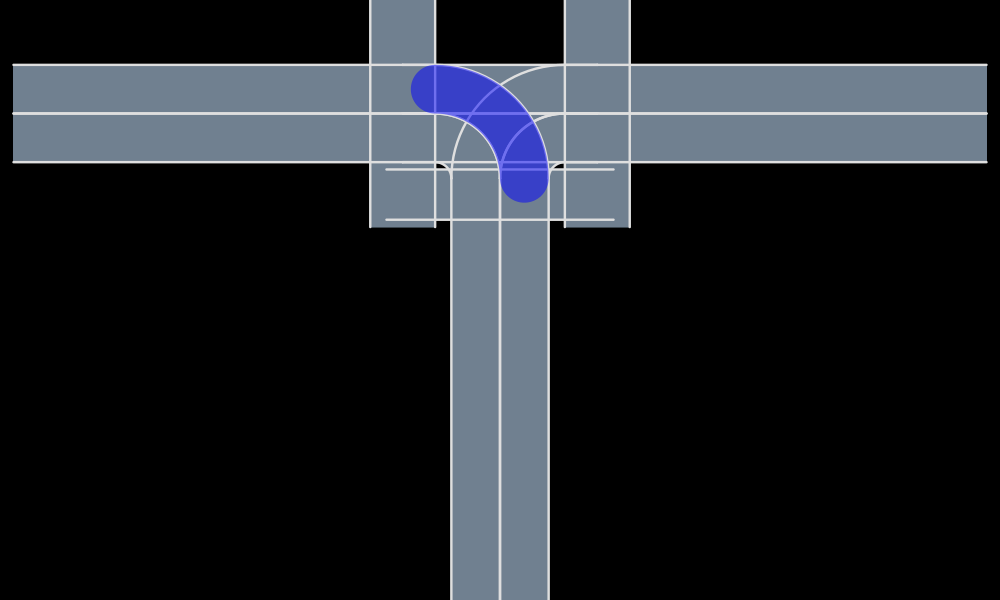

In [52]:
scene = Scene()
roadway = env.roadway
type LaneOverlay <: SceneOverlay
    lane::Lane
    color::Colorant
end
function AutoViz.render!(rendermodel::RenderModel, overlay::LaneOverlay, scene::Scene, roadway::Roadway)
    render!(rendermodel, overlay.lane, roadway, color_asphalt=overlay.color)
    return rendermodel
end
i = 13
render(scene, roadway, [LaneOverlay(roadway[LaneTag(i,1)], RGBA(0.0,0.0,1.0,0.5))], cam=cam)

In [7]:
@time state_space = states(mdp);

 70.573907 seconds (547.74 M allocations: 16.653 GiB, 12.76% gc time)


In [8]:
@assert n_states(mdp) == length(state_space)

In [9]:
@showprogress for (i, s) in enumerate(state_space)
    if i != state_index(mdp, s)
        println(i)
        println(s)
        break
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:02:1939m


In [10]:
struct StopPolicy <: Policy
end
function POMDPs.action(policy::StopPolicy, s)
    return UrbanAction(0.)
end

In [12]:
rand_pol = solve(RandomSolver(), mdp)
# rng = MersenneTwister(2)

hr = HistoryRecorder(rng=rng, max_steps=100)
s0 = initial_state(mdp, rng)
@time hist2 = simulate(hr, mdp, rand_pol, s0);
n_steps(hist2)

  0.032352 seconds (502.77 k allocations: 17.335 MiB)


100

In [13]:
h = hist2
state_hist = h.state_hist
action_hist = h.action_hist
push!(action_hist, UrbanAction(NaN))
duration, fps, render_hist = AutomotivePOMDPs.animate_states(mdp, state_hist, action_hist)
film = roll(render_hist, fps = fps, duration = duration)

Reel.Frames{MIME{Symbol("image/png")}}("/tmp/tmpVdQmgP", 0x0000000000000065, 2.0, nothing)

In [14]:
function AutomotivePOMDPs.animate_states(mdp::Union{PedCarMDP,CarMDP,PedMDP}, 
                                         states::Union{Vector{CarMDP}, Vector{PedMDP}, Vector{PedCarMDPState}},
                                         actions::Vector{UrbanAction};
                        overlays=SceneOverlay[IDOverlay()],
                        cam=StaticCamera(VecE2(0, -5.), 17.))
    duration = length(states)*mdp.ΔT
    fps = Int(1/mdp.ΔT)    
    function render_states(t, dt)
        frame_index = Int(floor(t/dt)) + 1
        scene = state2scene(mdp, states[frame_index])
        return AutoViz.render(scene,
                mdp.env,
              cat(1, overlays,   TextOverlay(text = ["v: $(get_ego(scene).state.v)"],
                                            font_size=20,
                                            pos=VecE2(mdp.env.params.x_min + 3.,6.),
                                            incameraframe=true),
                                 TextOverlay(text = ["Acc: $(actions[frame_index].acc)"],
                                            font_size=20,
                                            pos=VecE2(mdp.env.params.x_min + 3.,8.),
                                            incameraframe=true),
                                TextOverlay(text = ["step: $frame_index"],
                                            font_size=20,
                                            pos=VecE2(mdp.env.params.x_min + 3.,4.),
                                            incameraframe=true)),
                cam=cam,
                car_colors=get_colors(scene))
    end
    return duration, fps, render_states
end

## Profile Code

In [7]:
using ProfileView
using Traceur

In [8]:
@time state_space = states(mdp);

 50.841879 seconds (547.78 M allocations: 16.655 GiB, 14.22% gc time)


In [47]:
Profile.clear()

In [48]:
@time s = rand(rng, state_space)
@time for i=1:10000
    s = rand(rng, state_space)
    @profile d = transition(mdp, s, UrbanAction(0.))
end# 2e-3s

  0.000008 seconds (5 allocations: 496 bytes)
  4.621620 seconds (56.49 M allocations: 1.926 GiB, 23.25% gc time)


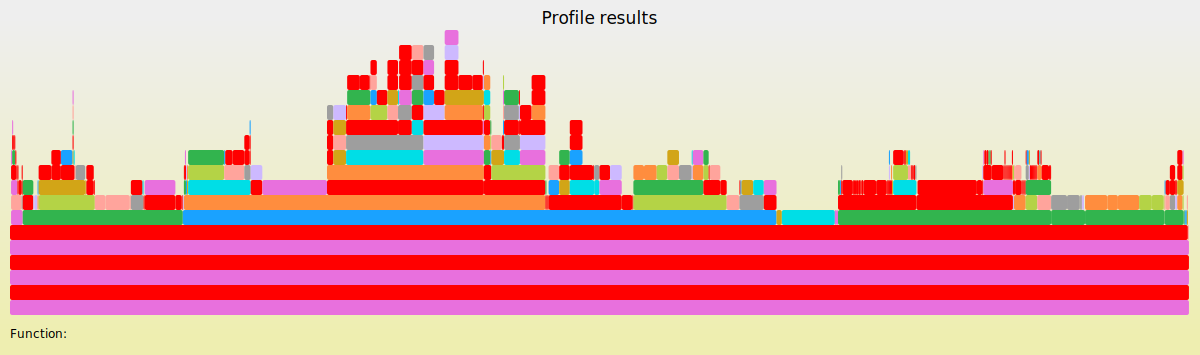

In [49]:
ProfileView.view()

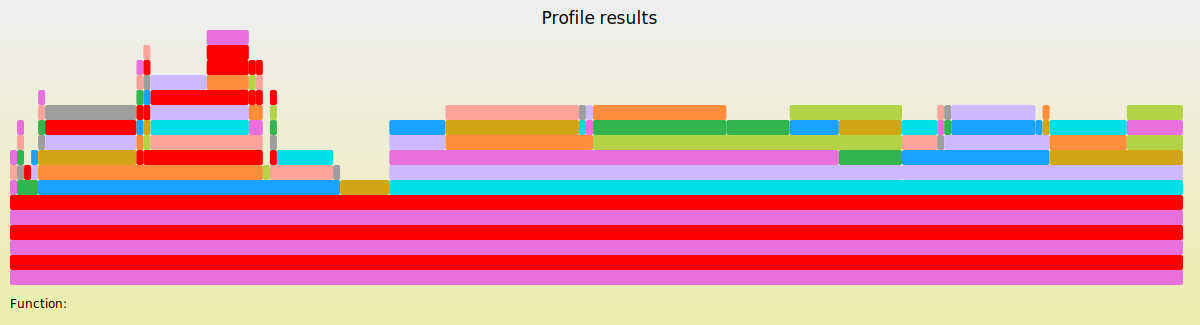

In [38]:
ProfileView.view()

In [59]:
fieldnames(LineSegment)

2-element Array{Symbol,1}:
 :A
 :B

In [60]:
methods(LineSegment)

# 3 methods for generic function "(::Type)":
Vec.LineSegment(A::Vec.VecE2, B::Vec.VecE2) in Vec at /mnt/c/Users/Maxime/wsl/.julia/v0.6/Vec/src/geom/line_segments.jl:6
Vec.LineSegment(A, B) in Vec at /mnt/c/Users/Maxime/wsl/.julia/v0.6/Vec/src/geom/line_segments.jl:6
(::Type{T})(arg) where T in Base at sysimg.jl:77

In [45]:
l = env.roadway[LaneTag(1,1)]
l.curve

2-element Array{AutomotiveDrivingModels.CurvePt,1}:
 CurvePt({30.000, 1.500, 3.142}, 0.000, NaN, NaN)
 CurvePt({6.000, 1.500, 3.142}, 24.000, NaN, NaN)

In [ ]:
@trace get_distance_to_crosswalk(mdp.car_model.crosswalk_drivers[1], state2scene(mdp, s))

In [22]:
posg = VecSE2(20., 6., float(pi))
l = mdp.env.roadway[LaneTag(1,1)]
@profile for i=1:1000; Frenet(posg, l, mdp.env.roadway); end

In [40]:
s = rand(rng, state_space);

## Value Iteration and MEC

In [6]:
using MDPModelChecking

In [12]:
mdp = PedMDP(env=env, pos_res=3.0, vel_res=2.)

AutomotivePOMDPs.PedMDP
  env: AutomotivePOMDPs.UrbanEnv
  ego_type: AutomotiveDrivingModels.VehicleDef
  ped_type: AutomotiveDrivingModels.VehicleDef
  ped_model: AutomotivePOMDPs.ConstantPedestrian
  max_acc: Float64 2.0
  pos_res: Float64 3.0
  vel_res: Float64 2.0
  vel_ped_res: Float64 1.0
  ego_start: Float64 20.0
  ego_goal: AutomotiveDrivingModels.LaneTag
  off_grid: Vec.VecSE2{Float64}
  ΔT: Float64 0.5
  ped_birth: Float64 0.3
  collision_cost: Float64 -1.0
  action_cost: Float64 0.0
  goal_reward: Float64 1.0
  γ: Float64 0.95


In [10]:
n_states(mdp)

70620

In [18]:
using JLD
data = load("ped_acc_states.jld")
# vi_policy = load("car_policy.jld")
# vi_policy = vi_policy["policy"]

Dict{String,Any} with 1 entry:
  "accepting_states" => Set(MDPModelChecking.ProductState{AutomotivePOMDPs.PedM…

In [42]:
acc_states = data["accepting_states"];
length(acc_states)

279

In [43]:
for s in acc_states
    println(s.q, " ", get_lane(mdp.env.roadway, s.s.ego).tag, " ", s.s.ped.posG, " ")
end

1 LaneTag(14, 1) VecSE2({-6.000, 5.000}, 1.571) 
1 LaneTag(13, 1) VecSE2({5.000, -5.000}, 0.000) 
1 LaneTag(2, 1) VecSE2({6.000, 5.000}, 1.571) 
1 LaneTag(2, 1) VecSE2({5.000, -5.000}, 0.000) 
1 LaneTag(2, 1) VecSE2({-6.000, 5.000}, 1.571) 
1 LaneTag(6, 1) VecSE2({5.000, -5.000}, 0.000) 
1 LaneTag(2, 1) VecSE2({6.000, 5.000}, 1.571) 
1 LaneTag(14, 1) VecSE2({-6.000, 5.000}, 1.571) 
1 LaneTag(6, 1) VecSE2({-6.000, 5.000}, 1.571) 
1 LaneTag(13, 1) VecSE2({-6.000, 5.000}, 1.571) 
1 LaneTag(2, 1) VecSE2({6.000, 5.000}, 1.571) 
1 LaneTag(13, 1) VecSE2({5.000, -5.000}, 0.000) 
1 LaneTag(6, 1) VecSE2({-6.000, 5.000}, 1.571) 
1 LaneTag(13, 1) VecSE2({5.000, -5.000}, 0.000) 
1 LaneTag(2, 1) VecSE2({-6.000, 5.000}, 1.571) 
1 LaneTag(2, 1) VecSE2({-6.000, 5.000}, 1.571) 
1 LaneTag(2, 1) VecSE2({-6.000, 5.000}, 1.571) 
1 LaneTag(2, 1) VecSE2({-6.000, 5.000}, 1.571) 
1 LaneTag(13, 1) VecSE2({5.000, -5.000}, 0.000) 
1 LaneTag(2, 1) VecSE2({6.000, 5.000}, 1.571) 
1 LaneTag(6, 1) VecSE2({5.000, -5.000

1 LaneTag(2, 1) VecSE2({-6.000, 5.000}, 1.571) 
1 LaneTag(6, 1) VecSE2({6.000, 5.000}, 1.571) 
1 LaneTag(2, 1) VecSE2({5.000, -5.000}, 0.000) 
1 LaneTag(2, 1) VecSE2({-6.000, 5.000}, 1.571) 
1 LaneTag(14, 1) VecSE2({5.000, -5.000}, 0.000) 
1 LaneTag(13, 1) VecSE2({6.000, 5.000}, 1.571) 
1 LaneTag(6, 1) VecSE2({6.000, 5.000}, 1.571) 
1 LaneTag(2, 1) VecSE2({6.000, 5.000}, 1.571) 
1 LaneTag(2, 1) VecSE2({-6.000, 5.000}, 1.571) 
1 LaneTag(13, 1) VecSE2({6.000, 5.000}, 1.571) 
1 LaneTag(2, 1) VecSE2({6.000, 5.000}, 1.571) 
1 LaneTag(6, 1) VecSE2({5.000, -5.000}, 0.000) 
1 LaneTag(6, 1) VecSE2({-6.000, 5.000}, 1.571) 
1 LaneTag(13, 1) VecSE2({5.000, -5.000}, 0.000) 
1 LaneTag(2, 1) VecSE2({5.000, -5.000}, 0.000) 
1 LaneTag(13, 1) VecSE2({5.000, -5.000}, 0.000) 
1 LaneTag(2, 1) VecSE2({5.000, -5.000}, 0.000) 
1 LaneTag(13, 1) VecSE2({-6.000, 5.000}, 1.571) 
1 LaneTag(6, 1) VecSE2({6.000, 5.000}, 1.571) 
1 LaneTag(2, 1) VecSE2({-6.000, 5.000}, 1.571) 
1 LaneTag(2, 1) VecSE2({5.000, -5.000}, 0

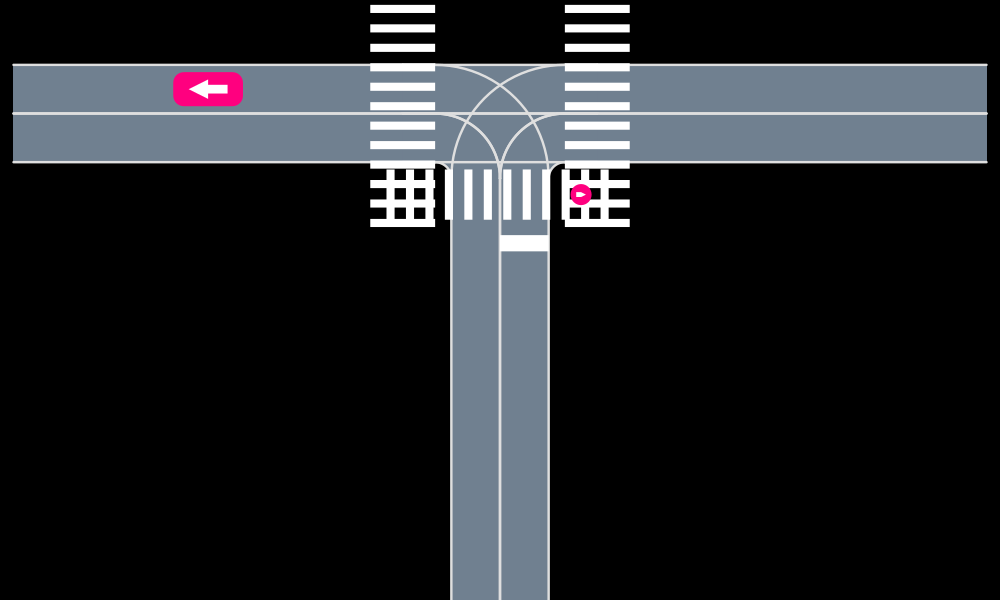

In [79]:
s = rand(acc_states)
scene = state2scene(mdp, s.s)
AutoViz.render(scene, env, cam=cam)

In [70]:
for s in policy.mdp.accepting_states
    println(s.q, " ", get_lane(mdp.env.roadway, s.s.ego).tag, " ", s.s.ped.posG, " ")
end

1 LaneTag(2, 1) VecSE2({6.000, -1.000}, 1.571) 
1 LaneTag(2, 1) VecSE2({6.000, -4.000}, 4.712) 
1 LaneTag(2, 1) VecSE2({6.000, -7.000}, 1.571) 
1 LaneTag(2, 1) VecSE2({-4.000, -5.000}, 0.000) 
1 LaneTag(2, 1) VecSE2({6.000, 5.000}, 1.571) 
1 LaneTag(2, 1) VecSE2({-7.000, -5.000}, 3.142) 
1 LaneTag(2, 1) VecSE2({6.000, -7.000}, 4.712) 
1 LaneTag(2, 1) VecSE2({-6.000, 5.000}, 4.712) 
1 LaneTag(2, 1) VecSE2({6.000, -1.000}, 1.571) 
1 LaneTag(2, 1) VecSE2({6.000, -7.000}, 4.712) 
1 LaneTag(2, 1) VecSE2({-7.000, -5.000}, 0.000) 
1 LaneTag(2, 1) VecSE2({6.000, -4.000}, 1.571) 
1 LaneTag(2, 1) VecSE2({-4.000, -5.000}, 3.142) 
1 LaneTag(2, 1) VecSE2({6.000, -7.000}, 1.571) 
1 LaneTag(2, 1) VecSE2({6.000, -1.000}, 4.712) 
1 LaneTag(2, 1) VecSE2({-6.000, 5.000}, 4.712) 
1 LaneTag(2, 1) VecSE2({-1.000, -5.000}, 0.000) 
1 LaneTag(2, 1) VecSE2({5.000, -5.000}, 3.142) 
1 LaneTag(2, 1) VecSE2({6.000, 2.000}, 4.712) 
1 LaneTag(2, 1) VecSE2({-6.000, -4.000}, 1.571) 
1 LaneTag(2, 1) VecSE2({-1.000, -5.0

1 LaneTag(2, 1) VecSE2({5.000, -5.000}, 3.142) 
1 LaneTag(2, 1) VecSE2({-7.000, -5.000}, 3.142) 
1 LaneTag(2, 1) VecSE2({-7.000, -5.000}, 0.000) 
1 LaneTag(2, 1) VecSE2({-6.000, 5.000}, 1.571) 
1 LaneTag(2, 1) VecSE2({-4.000, -5.000}, 3.142) 
1 LaneTag(2, 1) VecSE2({6.000, -7.000}, 1.571) 
1 LaneTag(2, 1) VecSE2({-4.000, -5.000}, 0.000) 
1 LaneTag(2, 1) VecSE2({-6.000, -1.000}, 4.712) 
1 LaneTag(2, 1) VecSE2({6.000, 2.000}, 4.712) 
1 LaneTag(2, 1) VecSE2({-6.000, -4.000}, 1.571) 
1 LaneTag(2, 1) VecSE2({-4.000, -5.000}, 3.142) 
1 LaneTag(2, 1) VecSE2({-6.000, -7.000}, 1.571) 
1 LaneTag(2, 1) VecSE2({-7.000, -5.000}, 3.142) 
1 LaneTag(2, 1) VecSE2({-6.000, 2.000}, 4.712) 
1 LaneTag(2, 1) VecSE2({6.000, 5.000}, 4.712) 
1 LaneTag(2, 1) VecSE2({6.000, -1.000}, 1.571) 
1 LaneTag(2, 1) VecSE2({6.000, -4.000}, 4.712) 
1 LaneTag(2, 1) VecSE2({5.000, -5.000}, 3.142) 
1 LaneTag(2, 1) VecSE2({-6.000, 5.000}, 4.712) 
1 LaneTag(2, 1) VecSE2({6.000, -7.000}, 4.712) 
1 LaneTag(2, 1) VecSE2({-6.000, -

1 LaneTag(2, 1) VecSE2({6.000, 5.000}, 4.712) 
1 LaneTag(2, 1) VecSE2({-6.000, 5.000}, 4.712) 
1 LaneTag(2, 1) VecSE2({-6.000, 2.000}, 4.712) 
1 LaneTag(2, 1) VecSE2({-1.000, -5.000}, 3.142) 
1 LaneTag(2, 1) VecSE2({2.000, -5.000}, 3.142) 
1 LaneTag(2, 1) VecSE2({6.000, -7.000}, 4.712) 
1 LaneTag(2, 1) VecSE2({-6.000, -4.000}, 1.571) 
1 LaneTag(2, 1) VecSE2({-6.000, -7.000}, 4.712) 
1 LaneTag(2, 1) VecSE2({-7.000, -5.000}, 3.142) 
1 LaneTag(2, 1) VecSE2({2.000, -5.000}, 0.000) 
1 LaneTag(2, 1) VecSE2({-6.000, 2.000}, 4.712) 
1 LaneTag(2, 1) VecSE2({6.000, 2.000}, 1.571) 
1 LaneTag(2, 1) VecSE2({-6.000, 5.000}, 1.571) 
1 LaneTag(2, 1) VecSE2({-6.000, -7.000}, 4.712) 
1 LaneTag(2, 1) VecSE2({-4.000, -5.000}, 3.142) 
1 LaneTag(2, 1) VecSE2({6.000, -4.000}, 4.712) 
1 LaneTag(2, 1) VecSE2({-6.000, 2.000}, 4.712) 
1 LaneTag(2, 1) VecSE2({-6.000, 5.000}, 4.712) 
1 LaneTag(2, 1) VecSE2({-7.000, -5.000}, 3.142) 
1 LaneTag(2, 1) VecSE2({-7.000, -5.000}, 0.000) 
1 LaneTag(2, 1) VecSE2({6.000, -4.

In [37]:
function goal_accepting!(mdp::ProductMDP{PedMDPState, UrbanAction, Q, T}; verbose::Bool=false) where {Q,T}
    for s in states(mdp)
        if isterminal(mdp.mdp, s.s) && !s.s.crash && s.q == 1
            push!(mdp.accepting_states, s)
        end
    end
    return mdp.accepting_states
end

goal_accepting! (generic function with 1 method)

In [38]:
acc_states = goal_accepting!(pmdp)

Set(MDPModelChecking.ProductState{AutomotivePOMDPs.PedMDPState,Int64}[MDPModelChecking.ProductState{AutomotivePOMDPs.PedMDPState,Int64}(AutomotivePOMDPs.PedMDPState(false, VehicleState(VecSE2({-30.000, 1.500}, 3.142), Frenet(RoadIndex({1, 1.000000}, {2, 1}), 24.000, 0.000, 0.000), 0.000), VehicleState(VecSE2({6.000, -1.000}, 1.571), Frenet(RoadIndex({1, 0.428571}, {17, 1}), 6.000, 0.000, 0.000), 2.000)), 1), MDPModelChecking.ProductState{AutomotivePOMDPs.PedMDPState,Int64}(AutomotivePOMDPs.PedMDPState(false, VehicleState(VecSE2({-30.000, 1.500}, 3.142), Frenet(RoadIndex({1, 1.000000}, {2, 1}), 24.000, 0.000, 0.000), 4.000), VehicleState(VecSE2({6.000, -4.000}, 4.712), Frenet(RoadIndex({1, 0.214286}, {17, 1}), 3.000, 0.000, 3.142), 2.000)), 1), MDPModelChecking.ProductState{AutomotivePOMDPs.PedMDPState,Int64}(AutomotivePOMDPs.PedMDPState(false, VehicleState(VecSE2({-30.000, 1.500}, 3.142), Frenet(RoadIndex({1, 1.000000}, {2, 1}), 24.000, 0.000, 0.000), 2.000), VehicleState(VecSE2({6.000

In [41]:
length(acc_states)

546